#### Project guidelines (comment to be removed)

https://github.com/suneman/socialdataanalysis2020/wiki/Final-Project


# Motivation.
merging Copenhagen traffic data with weather data to check if traffic volumes can be predicted over time and space


### What is your dataset?
* This dataset contains hourly data about some of the busiest roads in Copenhagen that is available from this oppen data page: 
https://www.opendata.dk/city-of-copenhagen/faste-trafiktaellinger#resource-faste_trafikt%C3%A6llinger_2008.xlsx


* The data reported are the total number of vehicles observed on these roads on each hour for all calendar days on each of the relevant roads


* Then for the weather we gathered data from.....


### Why did you choose this/these particular dataset(s)?
We thought it could be interesting to invesigate patterns in the data and try to forecast traffic volumes when we add weather data

### What was your goal for the end user's experience?
Building a tool that allows users to easily visualize the data in space and time and understand how thes traffic volumes/flows distribute across different timeframes, spaces/neighboroughs and weather conditions




# Basic stats. Let's understand the dataset better


### Write about your choices in data cleaning and preprocessing
We have deleted all the empty and oterwise irrelavant columns of data
Then we created new features, mostly time references that we will need to visualize the data by different time references: daily, weekly, yearly, etc.




In [1]:
!pip install utm

  Created wheel for utm: filename=utm-0.7.0-cp37-none-any.whl size=6096 sha256=2dbb4b7812f307790547f581c7eaf5a64e2d455f84eff6bb90908d81b7145e06
  Stored in directory: /root/.cache/pip/wheels/d3/a0/c4/93c7535fe705e70d2376505fd2683f91524a50a944a15212d9
Successfully built utm


In [3]:
#import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import utm

Downloading data and removing/adding features

In [4]:
df1 = pd.read_csv('https://raw.githubusercontent.com/LarsBryld/socialdata/main/cph_traffic_2005-2009_original.csv',
                 parse_dates = ['Dato'],dayfirst=True,encoding='ISO-8859-1')

df2 = pd.read_csv('https://raw.githubusercontent.com/LarsBryld/socialdata/main/cph_traffic_2010-2014_original.csv',
                 parse_dates = ['Dato'],dayfirst=True,encoding='ISO-8859-1')


print('len of first df is {}. Len of 2 df is {}.  '.format(len(df1), len(df2)))


len of first df is 93005. Len of 2 df is 90392.  


In [5]:
df = pd.DataFrame(pd.concat([df1, df2]))


In [6]:
for i in range(7,31):
    df = df.rename(columns={df.columns[i]: df.columns[i].split('.')[1].split('-')[0]})
    df[df.columns[i]] = df[df.columns[i]].str.replace(',', '').fillna(0).astype('float')



In [7]:
def uf(x):
    return utm.to_latlon(x[0], x[1], 32, 'T')
# then we apply this function to the UTM coordinates in the file
#df['LatLon'] = df[['Easting','Northing']].apply(uf, axis=1)
df[['Lat', 'Lon']] = pd.DataFrame(df[['(UTM32)','(UTM32).1']].apply(uf, axis=1).tolist(), index=df.index)

In [9]:
# randomizing Latitude and longitude points
mi, ma = 0, 0.02
# creating a noise with the same dimension as the dataset (2,2) 
noise1 = np.random.uniform(mi, ma, [len(df),1])
noise2 = np.random.uniform(mi, ma, [len(df),1]) 

In [10]:
df[['Lat_rand']] = df[['Lat']] + noise1
df[['Lon_rand']] = df[['Lon']] + noise2

In [11]:
df = df.drop(columns = ['Unnamed: 0','Spor','(UTM32)','(UTM32).1'])


In [12]:
# converting hours data columns into rows
df = df.melt(id_vars=["Vej-Id","Vejnavn","Dato","Lat","Lon","Lat_rand","Lon_rand"],
        value_vars=['00','01','02','03','04','05','06','07','08','09','10','11','12',
                    '13', '14','15', '16','17', '18','19','20','21','22','23'],
        var_name="Hour", 
        value_name="Vehicles")

In [62]:
# Add Day of the Week, Day, ,Week, Month, Year,
df["DayName"] = df['Dato'].apply(lambda x: x.day_name())
df["WeekDay"] = df['Dato'].dt.weekday
df["DayOfMonth"] = df['Dato'].dt.day
df["Week"] = df['Dato'].dt.week
df["Month"] = df['Dato'].dt.month
df["Year"] = df['Dato'].dt.year
df["WeekDayName"] = df['Dato'].dt.day_name()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,Vej-Id,Vejnavn,Dato,Lat,Lon,Lat_rand,Lon_rand,Hour,Vehicles,DayName,WeekDay,DayOfMonth,Week,Month,Year,WeekDayName
0,-,Ellebjergvej,2005-01-04,55.650543,12.510778,55.655616,12.526762,00,83.0,Tuesday,1,4,1,1,2005,Tuesday
1,-,Ellebjergvej,2005-02-04,55.650543,12.510778,55.666532,12.516093,00,153.0,Friday,4,4,5,2,2005,Friday
2,-,Ellebjergvej,2005-03-04,55.650543,12.510778,55.654095,12.514339,00,182.0,Friday,4,4,9,3,2005,Friday
3,-,Ellebjergvej,2005-04-04,55.650543,12.510778,55.666870,12.512420,00,57.0,Monday,0,4,14,4,2005,Monday
4,-,Ellebjergvej,2005-05-04,55.650543,12.510778,55.667396,12.528635,00,73.0,Wednesday,2,4,18,5,2005,Wednesday


In [14]:
# cleaning Vej-Id for more clear traffic direction
df['Vej-Id'] = df['Vej-Id'].str.split(n=4).str[-1]


### Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.


Below is the Total Count of vehicles per Road in descending order recorded in the whole period and a barplot that allows the visualization of the data.
From both the list and the plot below you can see how there are significant differences in traffic volumes among the roads chosen in the dataset

# remember to filter only for Vej-Id = "T" in all plots below (other tha the the ones for which you want to check for vehicles entering the City and the ones exiting)!!!!!!!

In [17]:
totcount = df.groupby('Vejnavn')['Vehicles'].sum().sort_values(ascending=False)
pd.DataFrame(totcount.values, index = list(totcount.index), columns =['Total Vehicles']) 

,Total Vehicles
Fredensbro,224539018.0
Ellebjergvej,208574520.0
Kalvebod Brygge,202649325.0
Torvegade,200340600.0
Tuborgvej,163046867.0
Ã boulevard,142917305.0
Vigerslev AllÃ©,123708668.0
Frederikssundsvej,121948873.0
Vejlands AlleÂ´,118548314.0
Hareskovvej,112475351.0


In [23]:
import plotly.express as px
fig = px.bar(totcount,  x = totcount.index, y = 'Vehicles', hover_data=[totcount.index, 'Vehicles'])

fig.update_layout(
    title="Total Vehicles pr. Street Name ",
    xaxis_title="Road Name",
    yaxis_title="Number of Vehicles",
    
  
)


fig.show()

# Let's look at how the data distribute across time
## Weekly distribution of total vehicles

The main pattern observable is the w-e drop in traffic

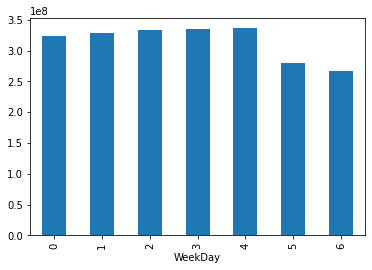

In [ ]:
w = df.groupby('WeekDay')['Vehicles'].sum().sort_values(ascending=False)

## Weekly distribution per Road
From the plots below a clear drop of traffic on all roads is clearly visible.
2 main exceptions to this pattern are:
* **Kalvebod Brygge** where the drop happens on Mondays and tuesdays. Althought this could be due to some quality issue about the data (we need to check if this is still the case when we include all years (now we are only working with 2008 data)
* **Jagtvej** shows a much lower drop in the w-e compared to other roads


In [65]:
w = df.groupby('WeekDayName')['Vehicles'].sum().sort_values(ascending=False)
w = pd.DataFrame(w.values, index = list(w.index), columns =['Total Vehicles']) 


In [89]:


fig = px.bar(df, x="WeekDayName", y="Vehicles", title="Day of Week pr steet", facet_col="Vejnavn", facet_col_wrap=6,)
fig.update_xaxes(categoryorder='array')
fig.update_xaxes(categoryarray= ['Monday','Tuesday','Wednesday','Thursday', 'Friday', 'December'])
#fig.update_yaxes(tick0=1, range=[0, 3500000000],dtick=500000000)
fig.show()


,Vej-Id,Vejnavn,Dato,Lat,Lon,Lat_rand,Lon_rand,Hour,Vehicles,DayName,WeekDay,DayOfMonth,Week,Month,Year,WeekDayName
0,-,Ellebjergvej,2005-01-04,55.650543,12.510778,55.655616,12.526762,00,83.0,Tuesday,1,4,1,1,2005,Tuesday
1,-,Ellebjergvej,2005-02-04,55.650543,12.510778,55.666532,12.516093,00,153.0,Friday,4,4,5,2,2005,Friday
2,-,Ellebjergvej,2005-03-04,55.650543,12.510778,55.654095,12.514339,00,182.0,Friday,4,4,9,3,2005,Friday
3,-,Ellebjergvej,2005-04-04,55.650543,12.510778,55.666870,12.512420,00,57.0,Monday,0,4,14,4,2005,Monday
4,-,Ellebjergvej,2005-05-04,55.650543,12.510778,55.667396,12.528635,00,73.0,Wednesday,2,4,18,5,2005,Wednesday


In [69]:
fig = px.bar(w,  x = w.index, y = 'Total Vehicles', hover_data=[w.index, 'Total Vehicles'],
            )



fig.update_layout(
    title="Total Vehicles pr. weekday",
    xaxis_title="WeeK Day",
    yaxis_title="Number of Vehicles",
    )

fig.update_xaxes(categoryorder='array', categoryarray= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

fig.show()

## Montly distribution per Road
* The main feature that is clearly visible is the drop in taffic on nearly all roads on July, which is the month where most Copenhageners are on holidays away from the city
* a few roads that except these rule show unclear patterns that could be due to data quality issues (check if this is true after wi enclose other years

In [ ]:
m = df.groupby(["Month", "Vejnavn"]).sum()["Vehicles"].unstack()

## Day of the month distribution per Road
one pattern that can be observed is that the 31st day of the month shows a little more than half the volumes of the average of the other days. This is probably due to the fact that there are ony 7 months that contain 31 days

In [ ]:
d = df.groupby(["DayOfMonth", "Vejnavn"]).sum()["Vehicles"].unstack()


## Hour of the day distribution per Road
one pattern that can be observed is that ......

In [ ]:
h = df.groupby(["Hour", "Vejnavn"]).sum()["Vehicles"].unstack()

In [ ]:
fig = px.bar(h, x="Hour", y="Vehicles", title="Day of Week <br>RFQ's from W&W ASSET MANAGEMENT", facet_col="Vejnavn", facet_col_wrap=6,)


In [ ]:
h.plot(kind='bar', subplots=True, figsize=(15,60), layout=(9,4))

## Yearly distribution per Road
* The main feature that is clearly visible is the drop in taffic on nearly all roads on July, which is the month where most Copenhageners are on holidays away from the city
* a few roads that except these rule show unclear patterns that could be due to data quality issues (check if this is true after wi enclose other years

In [ ]:
y = df.groupby(["Year", "Vejnavn"]).sum()["Vehicles"].unstack()
y

In [ ]:
y.plot(kind='bar', subplots=True, figsize=(15,60), layout=(9,4))

# Visualize data in space/time to identify some patterns

# Radhusplads

In [ ]:
import folium

map_hooray = folium.Map([55.6761, 12.5683], tiles = "Stamen Toner", zoom_start=12.5)

folium.Marker([55.6761, 12.5683], 
              popup='RadHus Plads', 
              icon=folium.Icon(color='blue')
             ).add_to(map_hooray)

map_hooray

# Visualizing some traffic data

In [ ]:
df1 = df[(df['DayOfMonth'].isin([1,2,3,4,5,2,3,4,5,6,7,8,9,10,
                                11,12,13,14,15,16,17,18,19,20,
                                21,22,23,24,25,26,27,28,29,30,31]))
         & (df['Hour'].isin(['07','08']))
         & (df['Month'].isin([6, 7]))
         & (df['Year'] == 2008)
        & (df['Vej-Id'] == 'T')]

df1

In [ ]:
map2 = folium.Map([55.6761, 12.5683], tiles = "Stamen Toner", zoom_start=12)

folium.Marker([55.6761, 12.5683], 
              popup='City Hall', 
              icon=folium.Icon(color='blue')
             ).add_to(map2)

for i in range(len(df1)):
    folium.Circle(location=[df1.iloc[i]['Lat'], df1.iloc[i]['Lon']],
                  popup=df1.iloc[i]['Month'],
                  radius=4, #data.iloc[i]['value']*10000,
                  color='crimson',
                  fill=True,
                  fill_color='crimson'
                 ).add_to(map2)

map2

# Heatmap

In [ ]:
from folium.plugins import HeatMap

map_hooray = folium.Map([55.6761, 12.5683], tiles = "Stamen Toner", zoom_start=12)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = df1[['Lat', 'Lon']]
#heat_df = heat_df.dropna(axis=0, subset=['Y','X'])



# List comprehension to make out list of lists
heat_data = [[row['Lat'],row['Lon']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(map_hooray)

# Display the map
map_hooray

# HeatMapWithTime  (Weekdays) 

In [ ]:
from folium import plugins

map_hooray = folium.Map([55.6761, 12.5683], tiles = "Stamen Toner", zoom_start=12)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = df1[['Lat', 'Lon','Lat_rand', 'Lon_rand']]
#heat_df = heat_df.dropna(axis=0, subset=['Y','X'])

# List comprehension to make out list of lists
heat_data = [[row['Lat'],row['Lon']] for index, row in heat_df.iterrows()]

# Create weight column, using date
heat_df['Weight'] = df1['WeekDay']
heat_df['Weight'] = heat_df['Weight'].astype(float)
heat_df = heat_df.dropna(axis=0, subset=['Lat','Lon', 'Weight'])

# List comprehension to make out list of lists
heat_data = [[[row['Lat'],row['Lon']] for index, row in heat_df[heat_df['Weight'] == i].iterrows()] for i in range(0,7)]

# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(map_hooray)
# Display the map
map_hooray

# HeatMapWithTime  (Weekdays) WITH RANDOMISED DATA

In [ ]:
#import numpy as np 
#mu, sigma = 0, 0.02
# creating a noise with the same dimension as the dataset (2,2) 
#noise1 = np.random.uniform(mu, sigma, [len(heat_df),1])
#noise2 = np.random.uniform(mu, sigma, [len(heat_df),1]) 

#heat_lat = heat_df[['Lat']] + noise1
#heat_lon = heat_df[['Lon']] + noise2

#heat_rn = pd.concat([heat_lat, heat_lon, heat_df['Weight']], axis=1)
#heat_rn
heat_df

In [ ]:
from folium import plugins

map_hooray = folium.Map([55.6761, 12.5683], tiles = "Stamen Toner", zoom_start=12)

# randomize traffic data
#mi, ma = 0, 0.02
# creating a noise with the same dimension as the dataset (2,2) 
#noise1 = np.random.uniform(mi, ma, [len(heat_df),1])
#noise2 = np.random.uniform(mi, ma, [len(heat_df),1]) 

#heat_lat = heat_df[['Lat']] + noise1
#heat_lon = heat_df[['Lon']] + noise2

#heat_rn = pd.concat([heat_lat, heat_lon, heat_df['Weight']], axis=1)
heat_rn = pd.concat([heat_df['Lat_rand'], heat_df['Lon_rand'], heat_df['Weight']], axis=1)

# List comprehension to make out list of lists
heat_data_rn = [[[row['Lat_rand'],row['Lon_rand']] for index, row in heat_rn[heat_rn['Weight'] == i].iterrows()] for i in range(0,7)]

# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data_rn,auto_play=True,max_opacity=0.8)
hm.add_to(map_hooray)
# Display the map
map_hooray

# HeatMapWithTime  (DaysOfMonth) 

In [ ]:
from folium import plugins

map_hooray = folium.Map([55.6761, 12.5683], tiles = "Stamen Toner", zoom_start=12)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = df1[['Lat', 'Lon']]
#heat_df = heat_df.dropna(axis=0, subset=['Y','X'])

# List comprehension to make out list of lists
heat_data = [[row['Lat'],row['Lon']] for index, row in heat_df.iterrows()]

# Create weight column, using date
heat_df['Weight'] = df1['WeekDay']
heat_df['Weight'] = heat_df['Weight'].astype(float)
heat_df = heat_df.dropna(axis=0, subset=['Lat','Lon', 'Weight'])

# List comprehension to make out list of lists
heat_data = [[[row['Lat'],row['Lon']] for index, row in heat_df[heat_df['Weight'] == i].iterrows()] for i in range(0,7)]

# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(map_hooray)
# Display the map
map_hooray

# another option to visualize something in the data is by using normalised data by road